<a href="https://colab.research.google.com/github/Khalid-Rafiq-01/Concrete-Crack-Classification/blob/main/Crack_Classification_Pre_Trained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Let us take the previous dataset (Concrete Crack Dataset) comprising of 40000 image and using a pre-trained model like MobileNetV2 for Classification.**

*We will employ the pre-trained model in two ways*

1. Feature Extraction and modifying the Classification head(Freezing all the Encoder layers with the hope that it would extract necessary features as it had been trained on a large ImageNet Dataset)
2. Fine Tuning (We would only unfreeze few top conv layers and train with a smaller Learning Rate)

#Pre-Processing the Dataset & Creating an Input pipeline

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!unzip '/content/drive/MyDrive/concrete dataset.zip'>/dev/null

In [3]:
positive_dir = '/content/Positive'
negative_dir = '/content/Negative'

In [ ]:
positive_path_dir = []
for dir, sub_dir, files in os.walk(positive_dir):
  files = sorted(files)
  for i in range(len(files)):
    positive_path_dir.append(os.path.join(dir, files[i]))

negative_path_dir = []
for dir, sub_dir, files in os.walk(negative_dir):
  files = sorted(files)
  for i in range(len(files)):
    negative_path_dir.append(os.path.join(dir, files[i]))


print(positive_path_dir)
print(negative_path_dir)
print(f'Number of images in the positive_path_dir are: {len(positive_path_dir)}')
print(f'Number of images in the negative_path_dir are: {len(negative_path_dir)}')

*Now we have created two lists for storing the paths for the positive and negative images resp.*

Next Let us create a pandas Series for filepath and the label

In [5]:
#Creating a dataframe for the positive dataset
positive_filepath_ser = pd.Series(positive_path_dir, name = 'Filepaths')
positive_filepath_label = pd.Series('POSITIVE', name = 'Lables',index = positive_filepath_ser.index)
# Let us concatinate both of these pandas series sideways, i.e axis = 1
positive_df = pd.concat([positive_filepath_ser, positive_filepath_label], axis = 1)

#Creating a dataframe for the negative dataset
negative_filepath_ser = pd.Series(negative_path_dir, name = 'Filepaths')
negative_filepath_label = pd.Series('NEGATIVE', name = 'Lables',index = negative_filepath_ser.index)
# Let us concatinate both of these pandas series sideways, i.e axis = 1
negative_df = pd.concat([negative_filepath_ser, negative_filepath_label], axis = 1)

*Let us print out both of these dataframes*

In [6]:
positive_df.head(3)

,Filepaths,Lables
0,/content/Positive/00001.jpg,POSITIVE
1,/content/Positive/00002.jpg,POSITIVE
2,/content/Positive/00003.jpg,POSITIVE


In [7]:
negative_df.head(3)

,Filepaths,Lables
0,/content/Negative/00001.jpg,NEGATIVE
1,/content/Negative/00002.jpg,NEGATIVE
2,/content/Negative/00003.jpg,NEGATIVE


*Concatinating both of these dataframes aling the hight dimension*

In [6]:
dataset_df = pd.concat([positive_df, negative_df], axis = 0)

In [9]:
dataset_df

,Filepaths,Lables
0,/content/Positive/00001.jpg,POSITIVE
1,/content/Positive/00002.jpg,POSITIVE
2,/content/Positive/00003.jpg,POSITIVE
3,/content/Positive/00004.jpg,POSITIVE
4,/content/Positive/00005.jpg,POSITIVE
...,...,...
19995,/content/Negative/19996.jpg,NEGATIVE
19996,/content/Negative/19997.jpg,NEGATIVE
19997,/content/Negative/19998.jpg,NEGATIVE
19998,/content/Negative/19999.jpg,NEGATIVE


*These is a problem with the index because the index number of the negative are remembered. we will reset the index and also shuffle the datframe along the rows*

In [7]:
dataset_df = pd.concat([positive_df, negative_df], axis = 0).reset_index(drop = True). sample(frac = 1, random_state = 42)

In [11]:
dataset_df

,Filepaths,Lables
32823,/content/Negative/12824.jpg,NEGATIVE
16298,/content/Positive/16299_1.jpg,POSITIVE
28505,/content/Negative/08506.jpg,NEGATIVE
6689,/content/Positive/06690.jpg,POSITIVE
26893,/content/Negative/06894.jpg,NEGATIVE
...,...,...
6265,/content/Positive/06266.jpg,POSITIVE
11284,/content/Positive/11285_1.jpg,POSITIVE
38158,/content/Negative/18159.jpg,NEGATIVE
860,/content/Positive/00861.jpg,POSITIVE


In [8]:
# Cross checking:
print(f'Length of the entire dataset is: {len(dataset_df)}')

p = dataset_df[(dataset_df['Lables'] == 'POSITIVE')]
print(f'Length of the positive dataset is: {len(p)}')

n = dataset_df[(dataset_df['Lables'] == 'NEGATIVE')]
print(f'Length of the negative dataset is: {len(n)}')

Length of the entire dataset is: 40000
Length of the positive dataset is: 20000
Length of the negative dataset is: 20000


**Now we have created a main dataset_df that contain all the positive and negative dataset info. We can now split this dataframe into train and test**

In [9]:
train_df, test_df = train_test_split(dataset_df, train_size=0.8, random_state=42, shuffle=True)

In [14]:
print(len(train_df))
print(len(test_df))

32000
8000


**Now we can preform image preprocessing and augmentation using ImageDataGenerator and later use flow from dataframe**

In [10]:
from keras.preprocessing.image import ImageDataGenerator #Pre-processing from Keras
train_preprocess = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale = 1./255, validation_split=0.2)
test_preprocess = ImageDataGenerator(rescale = 1./255)

In [11]:
train_ds = train_preprocess.flow_from_dataframe(train_df, x_col='Filepaths', y_col='Lables', target_size=(224, 224),
                                                color_mode='rgb', subset = 'training', class_mode='binary',
                                                batch_size=32, shuffle=True, seed=42)

val_ds = train_preprocess.flow_from_dataframe(train_df, x_col='Filepaths', y_col='Lables', target_size=(224, 224),
                                                color_mode='rgb', subset = 'validation', class_mode='binary',
                                                batch_size=32, shuffle=True, seed=42)

test_ds = test_preprocess.flow_from_dataframe(test_df, x_col='Filepaths', y_col='Lables', target_size=(224, 224),
                                                color_mode='rgb', class_mode='binary',
                                                batch_size=32, shuffle=False, seed=42)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


*Now we have successfully created a train, test and validtion dataset to be fed into the pre-trained model*

Shape of the images in first train iterator: (32, 224, 224, 3)
Shape of the labels in first train iterator: (32,)


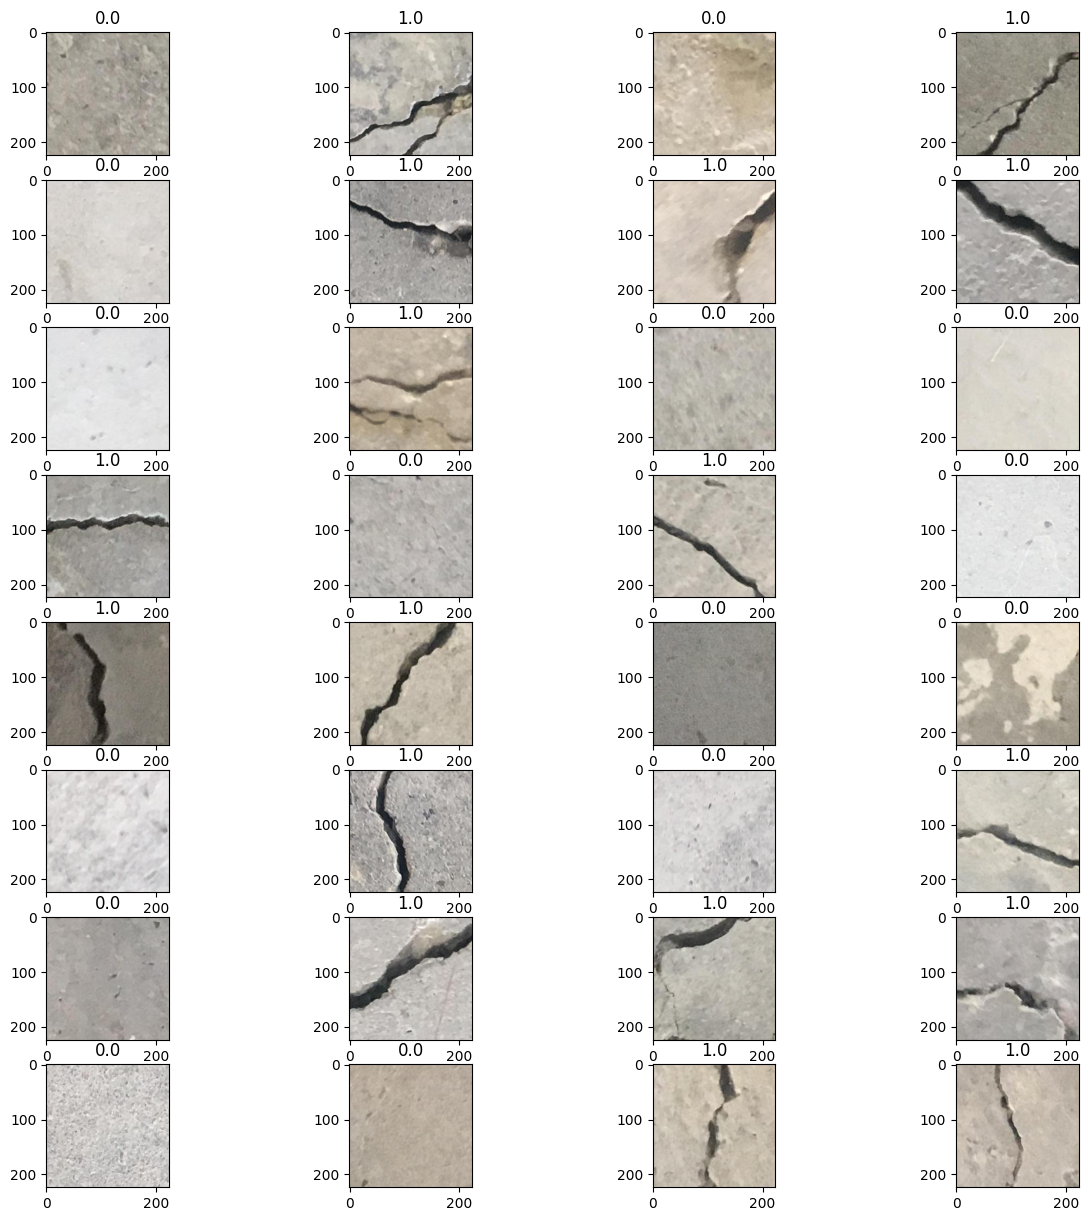

In [17]:
# Visualizing what is inside the the train_ds with its corresponding Labels
train_images, train_labels = next(train_ds)
print(f'Shape of the images in first train iterator: {train_images.shape}')
print(f'Shape of the labels in first train iterator: {train_labels.shape}')

plt.figure(figsize = (15,15))
for i in range(train_images.shape[0]):
  plt.subplot(8, 4, i+1)
  plt.imshow(train_images[i])
  plt.title(train_labels[i])


#Feature Extraction

**Let us now import a pre-trained MobileNet V2 model**

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

9406464/9406464 [==============================] - 1s 0us/step


In [19]:
base_model.trainable = False

In [20]:
from keras.applications.mobilenet_v2 import preprocess_input

*Defining the Model architecture*

In [21]:
from tensorflow import keras
from keras.layers import Dense, Input, Conv2D, GlobalAveragePooling2D, Dropout

In [22]:
inputs = keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training = False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  # Regularize with dropout
outputs = Dense(1, activation = 'sigmoid')(x)
model_feature_ext = keras.Model(inputs = inputs, outputs = outputs) 


In [23]:
model_feature_ext.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [24]:
# Compiling the model:
initial_lr = 0.001
model_feature_ext.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                          loss=tf.keras.losses.BinaryCrossentropy(),
                          metrics=keras.metrics.BinaryAccuracy())

In [25]:
#Deifining the Model Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath = 'pretrained_crack_model_feature_ext.h5'
callback_list = [ModelCheckpoint(filepath=filepath, save_best_only = True ),
                 EarlyStopping(patience=4)]

In [26]:
#Fitting the model:
initial_epochs = 10
feature_ext_history = model_feature_ext.fit(train_ds, validation_data = val_ds, epochs = initial_epochs, callbacks = callback_list)

Epoch 1/10
800/800 [==============================] - 102s 111ms/step - loss: 0.6338 - binary_accuracy: 0.6489 - val_loss: 0.5396 - val_binary_accuracy: 0.9259
Epoch 2/10
800/800 [==============================] - 82s 103ms/step - loss: 0.5142 - binary_accuracy: 0.8080 - val_loss: 0.4616 - val_binary_accuracy: 0.8386
Epoch 3/10
800/800 [==============================] - 82s 103ms/step - loss: 0.4523 - binary_accuracy: 0.8409 - val_loss: 0.3939 - val_binary_accuracy: 0.9116
Epoch 4/10
800/800 [==============================] - 87s 108ms/step - loss: 0.4128 - binary_accuracy: 0.8542 - val_loss: 0.3563 - val_binary_accuracy: 0.9459
Epoch 5/10
800/800 [==============================] - 82s 102ms/step - loss: 0.3848 - binary_accuracy: 0.8657 - val_loss: 0.3309 - val_binary_accuracy: 0.9539
Epoch 6/10
800/800 [==============================] - 85s 106ms/step - loss: 0.3665 - binary_accuracy: 0.8685 - val_loss: 0.3195 - val_binary_accuracy: 0.8900
Epoch 7/10
800/800 [=========================

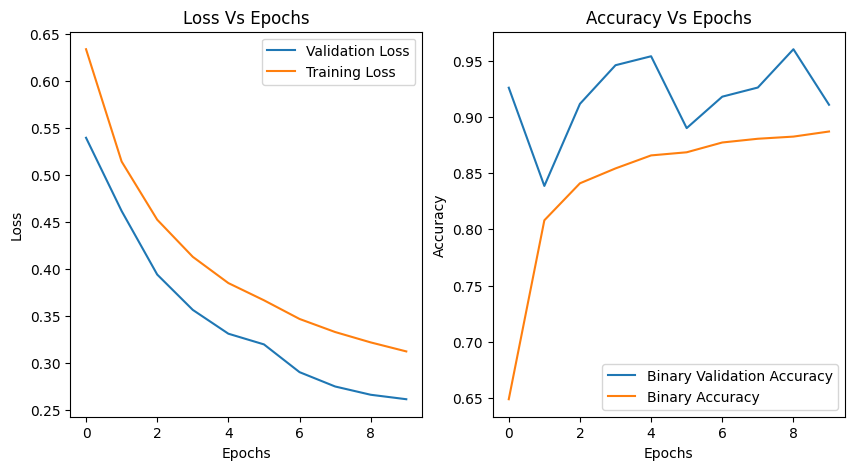

In [49]:
# Plotting the Validation Loss N Validation Accuracy against the number of Epochs:
import pandas as pd
feature_data = pd.DataFrame(feature_ext_history.history)
(a,b) = feature_data.shape

acc = feature_data['binary_accuracy']
val_acc = feature_data['val_binary_accuracy']
loss = feature_data['loss']
val_loss = feature_data['val_loss']

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(a), val_loss, label = "Validation Loss")
plt.plot(range(a), loss, label = "Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(a), val_acc, label = "Binary Validation Accuracy")
plt.plot(range(a), acc, label = "Binary Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epochs")
plt.legend()

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [29]:
#Let us create a similar function for evaluating the accuracy and creating the confusion matric and classification report
def evaluate(model, test_data):
  metrics = model.evaluate(test_data)
  loss = metrics[0]
  accuracy = metrics[1]
  print(f'The average loss of the trained model is: {loss}')
  print(f'The average accuracy of the model is: {accuracy}')

  pred = model.predict(test_data)
  y_pred = np.squeeze((pred>0.5).astype('int'))
  cm = confusion_matrix(test_data.labels, y_pred)
  clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])

  plt.figure(figsize=(5, 5))
  sns.heatmap(cm, annot = True, fmt = 'g', cmap='Blues', cbar=False)
  # plt.xticks(labels=["NEGATIVE", "POSITIVE"])
  # plt.yticks(labels=["NEGATIVE", "POSITIVE"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()
    
  print("Classification Report:\n----------------------\n", clr)



250/250 [==============================] - 18s 73ms/step - loss: 0.2845 - binary_accuracy: 0.8976
The average loss of the trained model is: 0.2845165431499481
The average accuracy of the model is: 0.8976250290870667
250/250 [==============================] - 20s 76ms/step


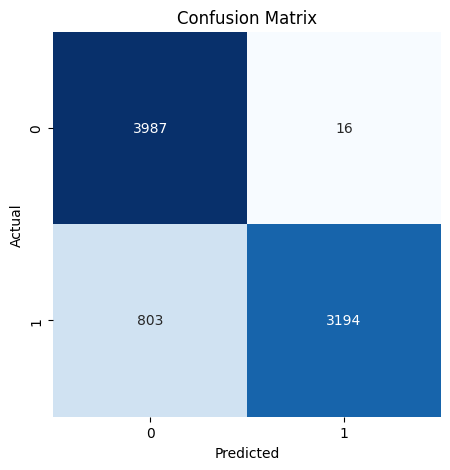

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.83      1.00      0.91      4003
    POSITIVE       1.00      0.80      0.89      3997

    accuracy                           0.90      8000
   macro avg       0.91      0.90      0.90      8000
weighted avg       0.91      0.90      0.90      8000



In [30]:
evaluate(model_feature_ext, test_ds)

#FineTuning

*Now the model is a trained model - i.e classification head is trained*

**Note** -- In order to apply Fine Tuning, generally the classification head should be already trained on the problem at hand. Otherwise the high gradients at the classification head, may result in a drastic weith change anf the unfrozen layers may un-learn all the ImageNet learned features 

In [31]:
base_model.trainable = True

In [32]:
# Let us print the number of layers in the base model:
print(f'Number of layers in the pretrained base model: {len(base_model.layers)}')

Number of layers in the pretrained base model: 154


*Let us start training the base-model from the 125th layer while keeping the bottom (0-125) layers frozen* 

In [33]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

for layer in base_model.layers[fine_tune_at:]:
  if isinstance(layer, keras.layers.BatchNormalization):
    layer.trainable = False

In [34]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [35]:
# How can I now display which of the layers are trainable:
trainable_layer = []
for layer in base_model.layers:
  if layer.trainable == True:
    trainable_layer.append(layer)
print(f'Length of the trainable layers in the Un-frozen base model are: {len(trainable_layer)}')

Length of the trainable layers in the Un-frozen base model are: 36


In [36]:
print(trainable_layer)

[<keras.layers.activation.relu.ReLU object at 0x7f87c0394a60>, <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f87c03cfa30>, <keras.layers.activation.relu.ReLU object at 0x7f87c02fe8b0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f87c02feeb0>, <keras.layers.merging.add.Add object at 0x7f87c03053a0>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f87c0301a60>, <keras.layers.activation.relu.ReLU object at 0x7f87c03163a0>, <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f87c03169d0>, <keras.layers.activation.relu.ReLU object at 0x7f87c0324130>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f87c0324f10>, <keras.layers.merging.add.Add object at 0x7f87c0334d00>, <keras.layers.convolutional.conv2d.Conv2D object at 0x7f87c0334700>, <keras.layers.activation.relu.ReLU object at 0x7f87c02c10a0>, <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f87c02c12e0>, <keras.layers.convolutional.depthwise_conv2

*Observe that all the Batch Normalization Layers have been Frozen*

In [37]:
# Compiling the model:
fine_tune_lr = initial_lr*0.0001
fine_tune_model = model_feature_ext
fine_tune_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr), # Taken as one-tenth of the earlier learning rate
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=keras.metrics.BinaryAccuracy())

In [38]:
fine_tune_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [39]:
filepath = 'pretrained_crack_model_fine_tune.h5'
callback_list_finetune = [ModelCheckpoint(filepath=filepath, save_best_only = True ),
                 EarlyStopping(patience=4)]

In [40]:
#Fitting the model and continuing the epohs from the earlier epochs number:

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
 
history_fine = fine_tune_model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=feature_ext_history.epoch[-1],
                         validation_data=val_ds,
                         callbacks = callback_list_finetune) 

Epoch 10/20
800/800 [==============================] - 103s 119ms/step - loss: 0.2531 - binary_accuracy: 0.9109 - val_loss: 0.1915 - val_binary_accuracy: 0.9422
Epoch 11/20
800/800 [==============================] - 96s 120ms/step - loss: 0.2283 - binary_accuracy: 0.9243 - val_loss: 0.1797 - val_binary_accuracy: 0.9436
Epoch 12/20
800/800 [==============================] - 93s 117ms/step - loss: 0.2195 - binary_accuracy: 0.9248 - val_loss: 0.1695 - val_binary_accuracy: 0.9561
Epoch 13/20
800/800 [==============================] - 84s 105ms/step - loss: 0.2087 - binary_accuracy: 0.9295 - val_loss: 0.1642 - val_binary_accuracy: 0.9628
Epoch 14/20
800/800 [==============================] - 84s 106ms/step - loss: 0.2000 - binary_accuracy: 0.9339 - val_loss: 0.1632 - val_binary_accuracy: 0.9481
Epoch 15/20
800/800 [==============================] - 84s 105ms/step - loss: 0.1940 - binary_accuracy: 0.9363 - val_loss: 0.1597 - val_binary_accuracy: 0.9477
Epoch 16/20
800/800 [==================

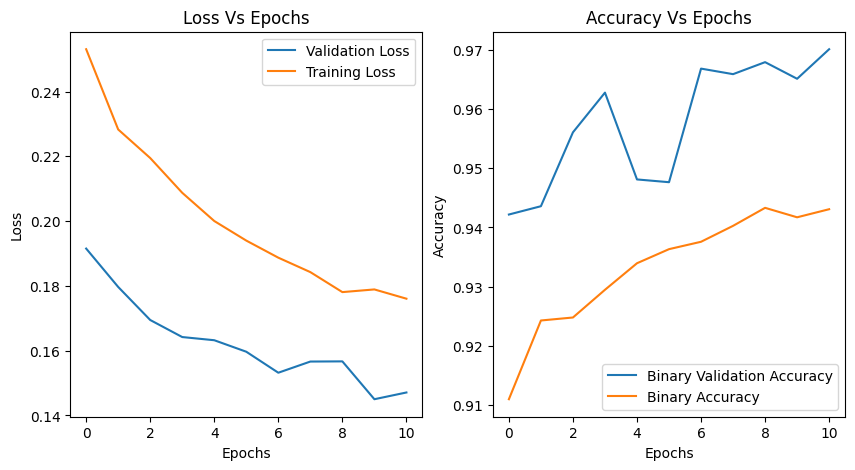

In [48]:
# Plotting the Validation Loss N Validation Accuracy against the number of Epochs:
data = pd.DataFrame(history_fine.history) # Creates a Pandas DataFrame
(a,b) = data.shape

acc = data['binary_accuracy']
val_acc = data['val_binary_accuracy']
loss = data['loss']
val_loss = data['val_loss']

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(a), val_loss, label = "Validation Loss")
plt.plot(range(a), loss, label = "Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(a), val_acc, label = "Binary Validation Accuracy")
plt.plot(range(a), acc, label = "Binary Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epochs")
plt.legend()

*Visualizing all the 20 epochs*

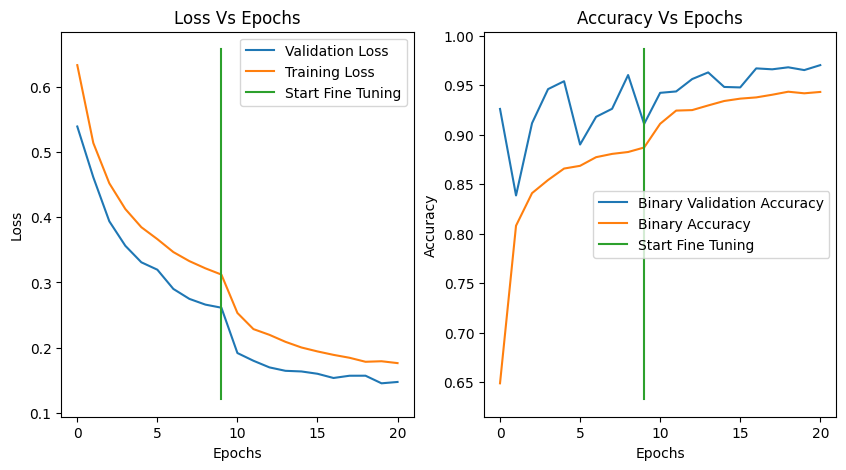

In [61]:
fine_dict = history_fine.history # Creates a dict
#Converting a dict to pandas dataframe:
fine_data = pd.DataFrame(fine_dict)
#Let us concatinate the Feature dataFrame and the Fine DataFrame to visualize both of them: adding colimn wise:
history_dataframe = pd.concat([feature_data, fine_data], axis = 0).reset_index(drop = True)
a = len(history_dataframe)

acc = history_dataframe['binary_accuracy']
val_acc = history_dataframe['val_binary_accuracy']
loss = history_dataframe['loss']
val_loss = history_dataframe['val_loss']

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(a), val_loss, label = "Validation Loss")
plt.plot(range(a), loss, label = "Training Loss")
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(a), val_acc, label = "Binary Validation Accuracy")
plt.plot(range(a), acc, label = "Binary Accuracy")
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epochs")
plt.legend()


250/250 [==============================] - 19s 74ms/step - loss: 0.1552 - binary_accuracy: 0.9631
The average loss of the trained model is: 0.15519729256629944
The average accuracy of the model is: 0.9631249904632568
250/250 [==============================] - 20s 75ms/step


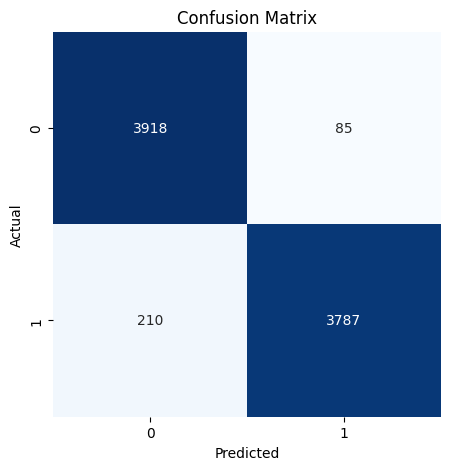

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.95      0.98      0.96      4003
    POSITIVE       0.98      0.95      0.96      3997

    accuracy                           0.96      8000
   macro avg       0.96      0.96      0.96      8000
weighted avg       0.96      0.96      0.96      8000



In [41]:
evaluate(fine_tune_model, test_ds)